In [1]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2021-11-28 18:08:22--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 34.64.4.80, 34.64.4.48, 34.64.4.112, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|34.64.4.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  4.58MB/s    in 14s     

2021-11-28 18:08:37 (4.59 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [2]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [3]:
import os
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

In [4]:
NUM_TRAIN_SAMPLE_PER_CLASS = 200
NUM_VALID_SAMPLE_PER_CLASS = 100
our_train_cat_fnames = os.listdir(train_cats_dir)[:NUM_TRAIN_SAMPLE_PER_CLASS]
our_train_dog_fnames = os.listdir(train_dogs_dir)[:NUM_TRAIN_SAMPLE_PER_CLASS]
our_valid_cat_fnames = os.listdir(validation_cats_dir)[:NUM_VALID_SAMPLE_PER_CLASS]
our_valid_dog_fnames = os.listdir(validation_dogs_dir)[:NUM_VALID_SAMPLE_PER_CLASS]

our_valid_cat_file_path = list(map(lambda x: os.path.join(validation_cats_dir,x), our_valid_cat_fnames))
our_valid_dog_file_path = list(map(lambda x: os.path.join(validation_dogs_dir,x), our_valid_dog_fnames))

In [5]:
our_train_cat_file_path = list(map(lambda x: os.path.join(train_cats_dir,x), our_train_cat_fnames))
our_train_dog_file_path = list(map(lambda x: os.path.join(train_dogs_dir,x), our_train_dog_fnames))

our_valid_cat_file_path = list(map(lambda x: os.path.join(validation_cats_dir,x), our_valid_cat_fnames))
our_valid_dog_file_path = list(map(lambda x: os.path.join(validation_dogs_dir,x), our_valid_dog_fnames))


In [6]:
# 고양이와 개 샘플을 하나로 묶어줍니다. 
our_train_file_path = our_train_cat_file_path + our_train_dog_file_path
our_valid_file_path = our_valid_cat_file_path + our_valid_dog_file_path

# 정답 데이터도 생성합니다. 0을 고양이, 1을 개로 설정하겠습니다.
train_ground_truth = [0 for _ in range(len(our_train_cat_file_path))] + [1 for _ in range(len(our_train_dog_file_path))]
valid_ground_truth = [0 for _ in range(len(our_valid_cat_file_path))] + [1 for _ in range(len(our_valid_dog_file_path))]

# zip을 이용하여 학습 샘플과 정답을 묶어줍니다.
train_dataset = list(zip(our_train_file_path, train_ground_truth))
valid_dataset = list(zip(our_valid_file_path, valid_ground_truth))

print('Train sample 개수: {}'.format(len(train_dataset)))
print('Validation sample 개수: {}'.format(len(valid_dataset)))

Train sample 개수: 400
Validation sample 개수: 200


In [8]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

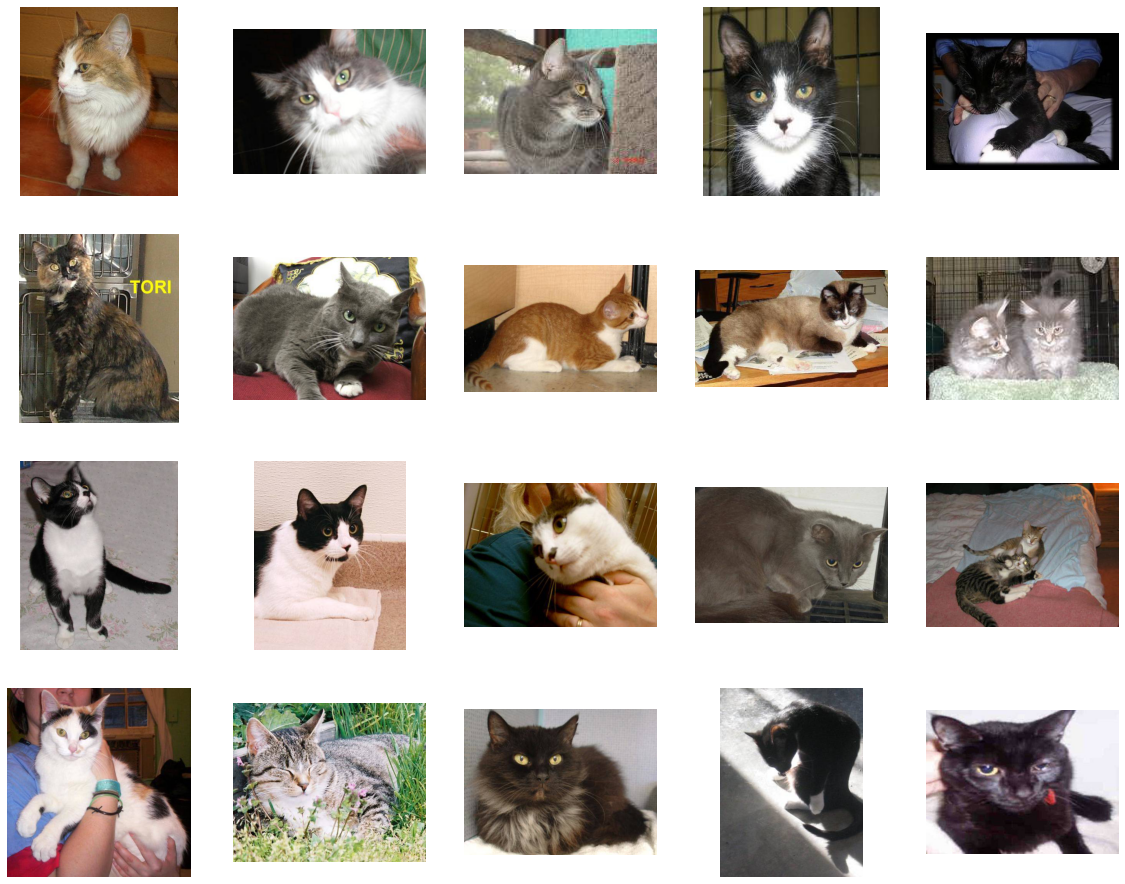

In [9]:
nrows = 4
ncols = 5

fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows *4)

for i, img_path in enumerate(our_valid_file_path):
    sp = plt.subplot(nrows, ncols, i+1)
    sp.axis('Off')
    
    img = mpimg.imread(img_path)
    plt.imshow(img)
    
    if i == 19:
        break
        
plt.show()

In [10]:
import torch

num_pixel = 128 * 128 * 3
num_class = 2

linear_model = torch.nn.Linear(num_pixel, num_class)
print (linear_model)

Linear(in_features=49152, out_features=2, bias=True)


In [13]:
from PIL import Image
from torchvision import transforms

resize_fn = transforms.Resize((128,128))
to_tensor = transforms.ToTensor()

test_image = Image.open(our_train_file_path[-1])

x = resize_fn(test_image)
print(x.size)

x = to_tensor(x)
print(x.shape)

flattened_x = x.flatten()
print(flattened_x.shape)

pred = linear_model(flattened_x)

print(pred)

(128, 128)
torch.Size([3, 128, 128])
torch.Size([49152])
tensor([-0.3945, -0.1220], grad_fn=<AddBackward0>)


dog


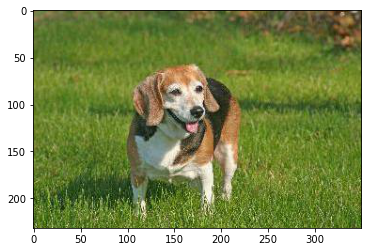

In [14]:
classifier_dict = {
    0: 'cat',
    1: 'dog'
}

pred_class = pred.argmax().item()
print(f'{classifier_dict[pred_class]}')

plt.imshow(test_image)
plt.show()

In [14]:
import random
import torch

linear_model = torch.nn.Linear(num_pixel, num_class)

random.shuffle(train_dataset)

optimizer = torch.optim.Adam(linear_model.parameters())

loss_fn = torch.nn.CrossEntropyLoss()

MAX_EPOCH = 150

transform = transforms.Compose( [transforms.Resize((128,128)), transforms.ToTensor()] )

PRINT_EVERY = 50

for ep in range(MAX_EPOCH):
    running_loss = 0.
    for i, (fname, y) in enumerate(train_dataset):
        image = Image.open(fname)
        
        x = transform(image)
        x = x.flatten().view(1,-1)
        # print(x.shape)
        
        # break
        
        pred = linear_model(x)
        
        gt = torch.zeros((1,2), dtype=torch.float32)
        gt[0][y] = 1.0
        
        loss = loss_fn(pred, gt)
        
        running_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        if (i+1) % PRINT_EVERY == 0:
            print(f'{ep+1}/{MAX_EPOCH} - {i+1}/{len(train_dataset)} Loss: {running_loss/PRINT_EVERY}')
            running_loss = 0.

NameError: name 'train_dataset' is not defined

In [27]:
accuracy = 0

for i, (fname, y) in enumerate(valid_dataset):
    image = Image.open(fname)
        
    x = transform(image)
    x = x.flatten().view(1,-1)
    # print(x.shape)
        
    # break
        
    pred = linear_model(x)
    
    pred_class = pred.argmax().item()
    
    if pred_class == y:
        accuracy += 1
        
    print (i+1, y, pred_class)
    
print('test accuracy:{}'.format(accuracy/len(valid_dataset)))    

1 0 0
2 0 0
3 0 1
4 0 0
5 0 0
6 0 1
7 0 0
8 0 0
9 0 0
10 0 0
11 0 0
12 0 0
13 0 0
14 0 1
15 0 0
16 0 0
17 0 1
18 0 1
19 0 1
20 0 1
21 0 1
22 0 0
23 0 1
24 0 1
25 0 1
26 0 0
27 0 0
28 0 1
29 0 0
30 0 1
31 0 0
32 0 0
33 0 0
34 0 0
35 0 1
36 0 0
37 0 0
38 0 1
39 0 1
40 0 1
41 0 0
42 0 0
43 0 0
44 0 0
45 0 0
46 0 0
47 0 1
48 0 1
49 0 0
50 0 0
51 0 1
52 0 0
53 0 0
54 0 1
55 0 0
56 0 1
57 0 0
58 0 1
59 0 0
60 0 0
61 0 1
62 0 1
63 0 0
64 0 1
65 0 0
66 0 1
67 0 0
68 0 0
69 0 0
70 0 1
71 0 0
72 0 0
73 0 0
74 0 0
75 0 0
76 0 0
77 0 0
78 0 0
79 0 1
80 0 1
81 0 0
82 0 1
83 0 0
84 0 0
85 0 0
86 0 1
87 0 1
88 0 0
89 0 1
90 0 1
91 0 1
92 0 0
93 0 1
94 0 1
95 0 0
96 0 0
97 0 1
98 0 0
99 0 0
100 0 0
101 1 0
102 1 1
103 1 0
104 1 0
105 1 0
106 1 1
107 1 1
108 1 1
109 1 1
110 1 1
111 1 1
112 1 0
113 1 0
114 1 1
115 1 1
116 1 1
117 1 0
118 1 1
119 1 1
120 1 1
121 1 1
122 1 0
123 1 1
124 1 0
125 1 1
126 1 1
127 1 1
128 1 0
129 1 1
130 1 0
131 1 1
132 1 0
133 1 1
134 1 1
135 1 1
136 1 1
137 1 0
138 1 0
139 

In [11]:
from PIL import Image
from torchvision import transforms
import random
import torch

hidden_size = 100

first_layer  = torch.nn.Linear(num_pixel, hidden_size)
second_layer = torch.nn.Linear(hidden_size, num_class)
relu = torch.nn.ReLU()

optimizer = torch.optim.Adam(
     list(first_layer.parameters()) + list(second_layer.parameters()),
     lr=1e-4 )

loss_fn = torch.nn.CrossEntropyLoss()
MAX_EPOCH = 150
PRINT_EVERY = 50

for ep in range(MAX_EPOCH):
    running_loss = 0.
    for i, (fname, y) in enumerate(train_dataset):
        image = Image.open(fname)
        
        x = transform(image)
        x = x.flatten().view(1,-1)
        # print(x.shape)
        
        # break
        
        h = first_layer(x)
        h = relu(h)
        pred = second_layer(h)
        
        gt = torch.zeros((1,2), dtype=torch.float32)
        gt[0][y] = 1.0
        
        loss = loss_fn(pred, gt)
        
        running_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        if (i+1) % PRINT_EVERY == 0:
            print(f'{ep+1}/{MAX_EPOCH} - {i+1}/{len(train_dataset)} Loss: {running_loss/PRINT_EVERY}')
            running_loss = 0.


NameError: name 'transform' is not defined

In [30]:
import torch
num_pixel = 128 * 128 * 3
num_class = 2 

conv1 = torch.nn.Conv2d(3,20,kernel_size = 3, stride =1, padding =1)
conv2 = torch.nn.Conv2d(20,50,kernel_size = 3, stride =1, padding =1)
relu = torch.nn.ReLU(inplace=True)
maxpool = torch.nn.MaxPool2d(kernel_size=2, stride=2)

linear1 = torch.nn.Linear(50*32*32, 500)
linear2 = torch.nn.Linear(500, num_class)



In [ ]:
# optimizer를 새로 생성합니다.
optimizer = torch.optim.Adam(
    list(conv1.parameters()) + list(conv2.parameters()) + list(linear1.parameters()) + list(linear2.parameters()),
    lr=1e-4, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-5
)
loss_fn = torch.nn.CrossEntropyLoss()
MAX_EPOCH = 150
PRINT_EVERY = 50
transform = transforms.Compose([transforms.Resize((128, 128)), transforms.ToTensor()])

optimizer.zero_grad()
for ep in range(MAX_EPOCH):
  running_loss = 0.
  for i, (fname, y) in enumerate(train_dataset):
    image = Image.open(fname)

    x = transform(image)
    x = x.view(1, 3, 128, 128) #! 이제 입력x를 flatten하지 않고 그대로 이용합니다.

    '''----- forward pass -----'''
    x = maxpool(relu(conv1(x)))
    x = maxpool(relu(conv2(x)))
    
    x = x.flatten().view(1,-1) 
    
    h = relu(linear1(x))
    pred = linear2(h)
        
    # gt에 대한 tensor를 만들어 줍니다. (loss연산을 위하여)
    gt = torch.zeros((1,2), dtype=torch.float32)
    gt[0][y] = 1.0 # [[1,0]] or [[0,1]] 의 값을 가집니다. 
    
    loss = loss_fn(pred, gt) # PyTorch의 corss-entropy loss는 logits으로부터 자동으로 확률을 계산해줍니다.
                     # reminder: softmax(logits) = probability
    
    running_loss += loss.item()
    
    '''----- backward pass -----'''
    # backpropagation을 이용해 gradient를 계산하고,
    loss.backward()
    # gradient descent를 통해 weight를 업데이트합니다.
    optimizer.step()
    # 마지막으로 그 다음 gradient 계산을 위하여 초기화를 해줍니다.
    optimizer.zero_grad()

    if (i+1) % PRINT_EVERY == 0: #  매 N번의 반복마다 loss 값을 출력해줍니다.
    #if True:
      print(f'{ep+1}/{MAX_EPOCH} - {i+1}/{len(train_dataset)} Loss: {running_loss/PRINT_EVERY}')
      running_loss = 0.

1/150 - 50/400 Loss: 0.01799254450265252
